# 📊 NSE Stock Closing Price Prediction - Complete ML Workflow

**Objective**: Predict next-day closing prices using LSTM, RNN, and Prophet models

**Author**: Thesis Project  
**Date**: November 2025

---

## Workflow Overview

This notebook follows the complete machine learning workflow:

1. **Data Collection & Understanding**
2. **Data Preprocessing & Cleaning**
3. **Exploratory Data Analysis (EDA)**
4. **Feature Engineering**
5. **Model Development**
   - LSTM
   - RNN
   - Prophet
6. **Model Evaluation & Comparison**
7. **Results Visualization**
8. **Conclusions & Future Work**

---
## ⚠️ Important: Data Configuration

**Current Dataset**: 42 trading days (Aug 4 - Nov 1, 2025)  
**Lookback Window**: 10 days (optimized for available data)  
**Training Epochs**: 50 (faster training)

The parameters in this notebook have been automatically adjusted based on your actual data availability.

---


---
## 1. Setup & Data Collection

In [1]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv

# ML libraries
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet import Prophet

# Custom modules
from closing_price_pipeline import (
    DailyDataAggregator,
    LSTMPredictor,
    RNNPredictor,
    ProphetPredictor,
    ModelComparator
)

# Setup
load_dotenv()
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Libraries loaded successfully")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✅ Libraries loaded successfully
TensorFlow version: 2.20.0
NumPy version: 2.3.3
Pandas version: 2.3.3


### Database Connection

In [2]:
# Database configuration
DB_CONFIG = {
    "dbname": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USER"),
    "password": os.getenv("DB_PASSWORD"),
    "host": os.getenv("DB_HOST"),
    "port": os.getenv("DB_PORT")
}

print("Database Configuration:")
print(f"  Database: {DB_CONFIG['dbname']}")
print(f"  Host: {DB_CONFIG['host']}:{DB_CONFIG['port']}")
print(f"  User: {DB_CONFIG['user']}")

Database Configuration:
  Database: nse
  Host: localhost:5432
  User: postgres


### Load Data

In [3]:
# Initialize aggregator
aggregator = DailyDataAggregator(DB_CONFIG)

# Fetch daily closing prices
print("Fetching daily closing prices from database...")
df_all = aggregator.get_daily_closing_prices(days_back=90)

print(f"\n📊 Data Summary:")
print(f"  Total records: {len(df_all):,}")
print(f"  Unique stocks: {df_all['symbol'].nunique()}")
print(f"  Date range: {df_all['trading_date'].min()} to {df_all['trading_date'].max()}")
print(f"  Days of data: {(df_all['trading_date'].max() - df_all['trading_date'].min()).days}")

# Display sample
df_all.head(10)

Fetching daily closing prices from database...


2025-11-01 04:56:14,509 - INFO - Fetched 2948 daily records for 71 symbols



📊 Data Summary:
  Total records: 2,948
  Unique stocks: 71
  Date range: 2025-08-04 to 2025-11-01
  Days of data: 89


,symbol,trading_date,close_price,daily_high,daily_low,daily_volume
0,ABSA,2025-08-04,19.50,19.7,19.50,5.831020e+07
1,ABSA,2025-08-05,19.55,19.7,19.50,1.075045e+08
2,ABSA,2025-08-06,19.65,19.7,19.50,1.035513e+08
3,ABSA,2025-08-07,19.70,19.9,19.55,4.228599e+08
4,ABSA,2025-08-08,19.85,19.9,19.65,2.781488e+08
5,ABSA,2025-08-11,19.95,20.0,19.65,5.495960e+07
6,ABSA,2025-08-12,19.95,20.0,19.70,4.861566e+07
7,ABSA,2025-08-13,19.80,20.0,19.55,6.352047e+07
8,ABSA,2025-08-14,20.00,20.0,19.55,1.268759e+09
9,ABSA,2025-08-15,19.95,20.0,19.55,8.605468e+07


---
## 2. Data Understanding & Quality Check

In [4]:
# Check for missing values
print("Missing Values:")
print(df_all.isnull().sum())

# Data types
print("\nData Types:")
print(df_all.dtypes)

# Summary statistics
print("\nSummary Statistics:")
df_all.describe()

Missing Values:
symbol            0
trading_date      0
close_price     109
daily_high      662
daily_low       662
daily_volume      0
dtype: int64

Data Types:
symbol           object
trading_date     object
close_price     float64
daily_high      float64
daily_low       float64
daily_volume    float64
dtype: object

Summary Statistics:


,close_price,daily_high,daily_low,daily_volume
count,2839.000000,2286.000000,2286.000000,2.948000e+03
mean,154.331261,139.918561,132.083605,1.719044e+08
std,549.676903,547.994805,502.820370,8.872269e+08
min,0.270000,0.300000,0.270000,0.000000e+00
25%,5.040000,7.680000,7.200000,9.653500e+03
50%,15.250000,18.150000,17.150000,3.343724e+06
75%,56.000000,62.562500,57.000000,4.647026e+07
max,5100.000000,7940.000000,5050.000000,1.862355e+10



Data Availability by Stock:
symbol
ABSA    42
NBV     42
SASN    42
PORT    42
OCH     42
NSE     42
NMG     42
NCBA    42
MSC     42
SCAN    42
dtype: int64


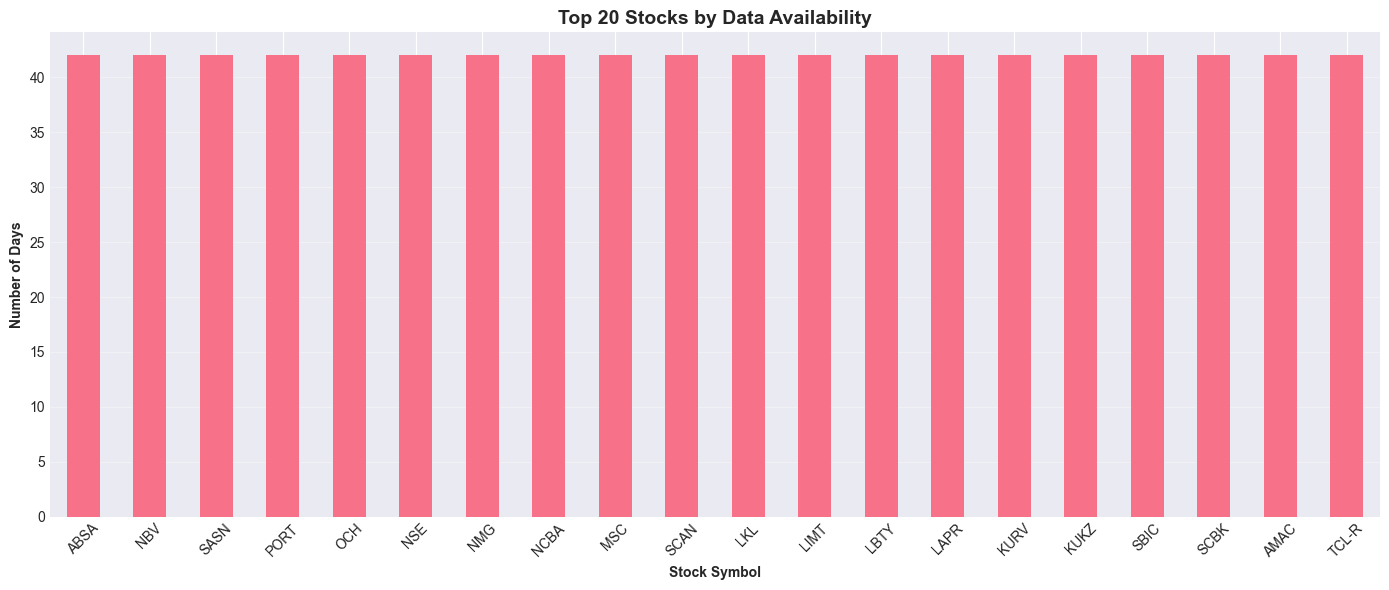


Stocks with 60+ days: 0
Stocks with 30-59 days: 69
Stocks with < 30 days: 2


In [5]:
# Data availability per stock
stock_counts = df_all.groupby('symbol').size().sort_values(ascending=False)

print("\nData Availability by Stock:")
print(stock_counts.head(10))

# Visualize
plt.figure(figsize=(14, 6))
stock_counts.head(20).plot(kind='bar')
plt.title('Top 20 Stocks by Data Availability', fontsize=14, fontweight='bold')
plt.xlabel('Stock Symbol', fontweight='bold')
plt.ylabel('Number of Days', fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nStocks with 60+ days: {(stock_counts >= 60).sum()}")
print(f"Stocks with 30-59 days: {((stock_counts >= 30) & (stock_counts < 60)).sum()}")
print(f"Stocks with < 30 days: {(stock_counts < 30).sum()}")

---
## 3. Exploratory Data Analysis (EDA)

### 3.1 Price Trends Analysis

Analyzing: ['ABSA', 'NBV', 'SASN', 'PORT', 'OCH']


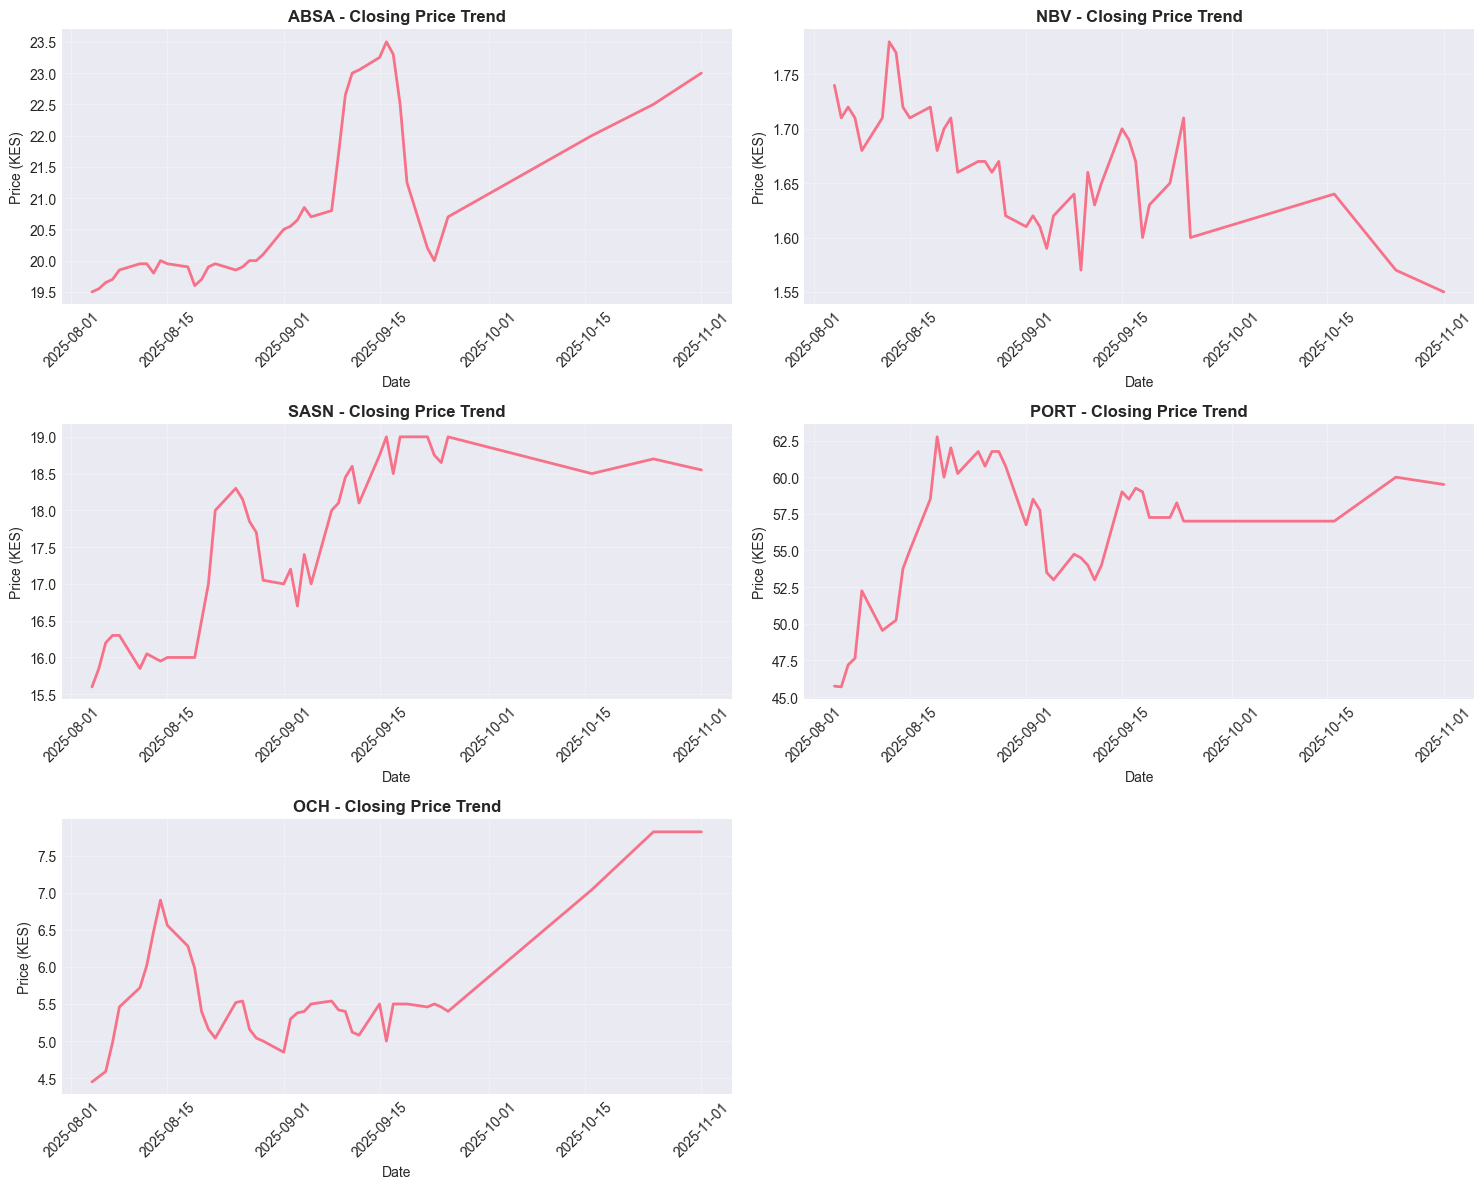

In [6]:
# Select top 5 stocks by data availability
top_stocks = stock_counts.head(5).index.tolist()
print(f"Analyzing: {top_stocks}")

# Plot price trends
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, symbol in enumerate(top_stocks):
    df_stock = df_all[df_all['symbol'] == symbol].sort_values('trading_date')
    
    axes[idx].plot(df_stock['trading_date'], df_stock['close_price'], linewidth=2)
    axes[idx].set_title(f'{symbol} - Closing Price Trend', fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Price (KES)')
    axes[idx].grid(alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

### 3.2 Volume Analysis

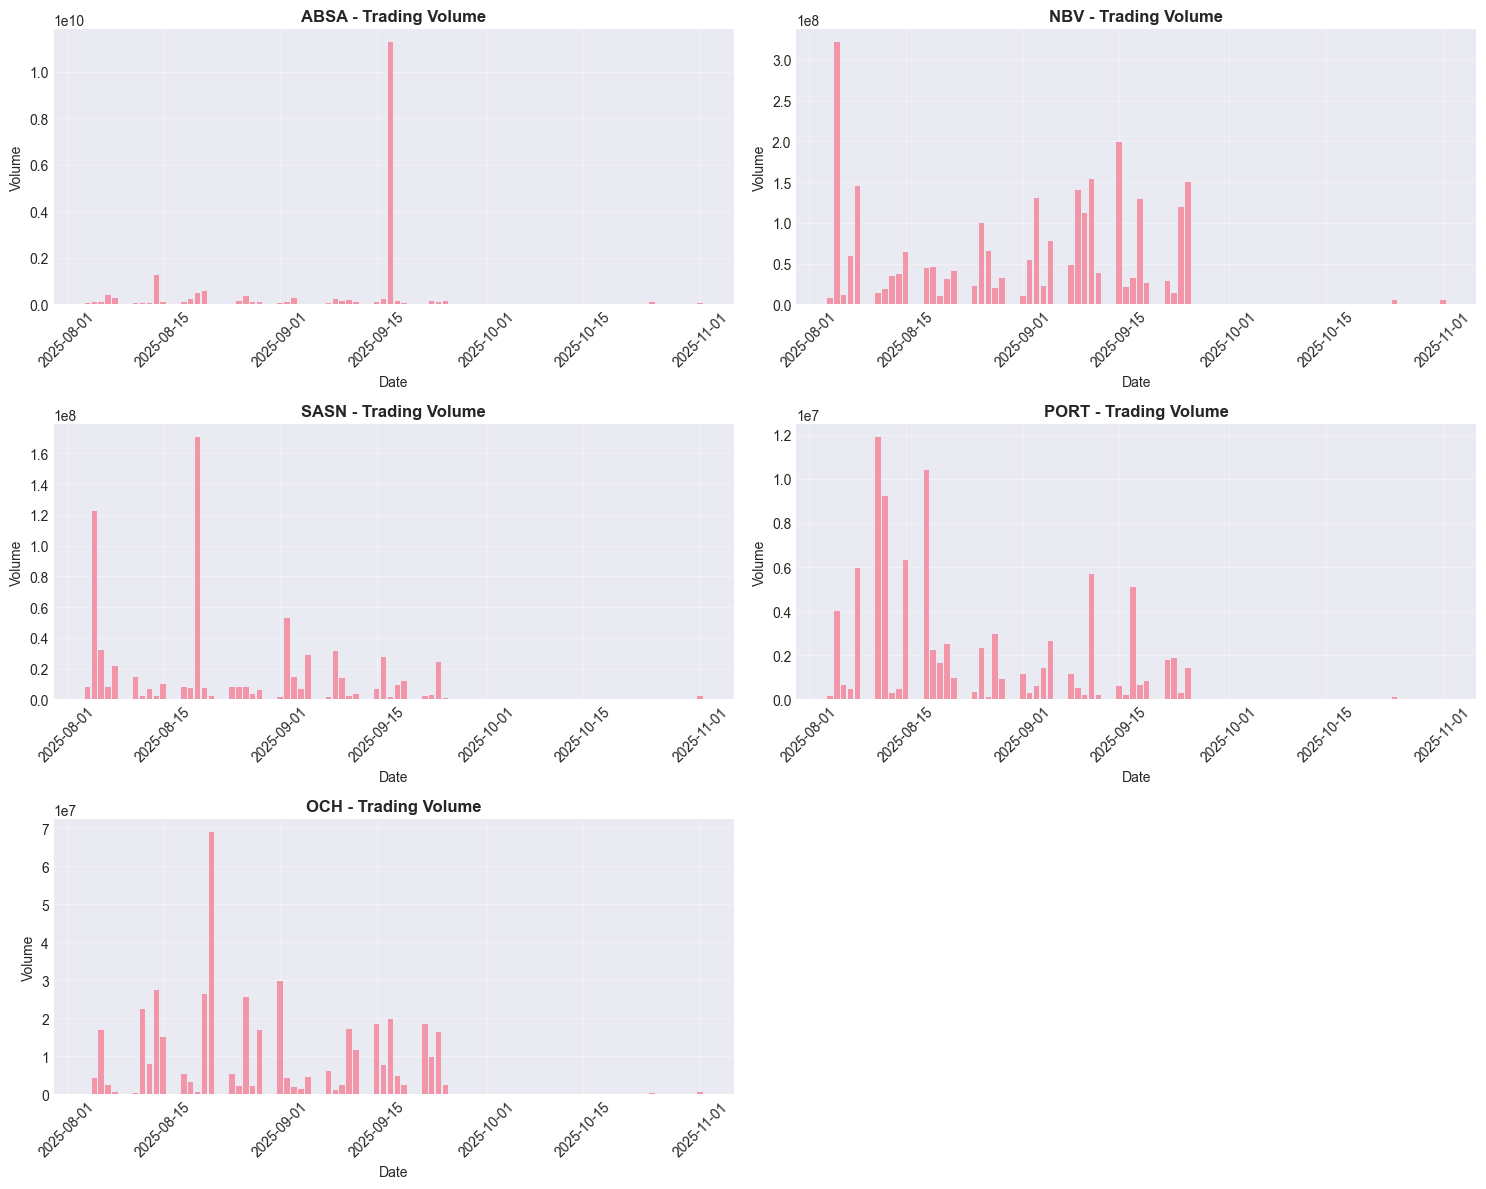

In [7]:
# Volume analysis
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, symbol in enumerate(top_stocks):
    df_stock = df_all[df_all['symbol'] == symbol].sort_values('trading_date')
    
    axes[idx].bar(df_stock['trading_date'], df_stock['daily_volume'], alpha=0.7)
    axes[idx].set_title(f'{symbol} - Trading Volume', fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Volume')
    axes[idx].grid(alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

### 3.3 Price Distribution & Volatility

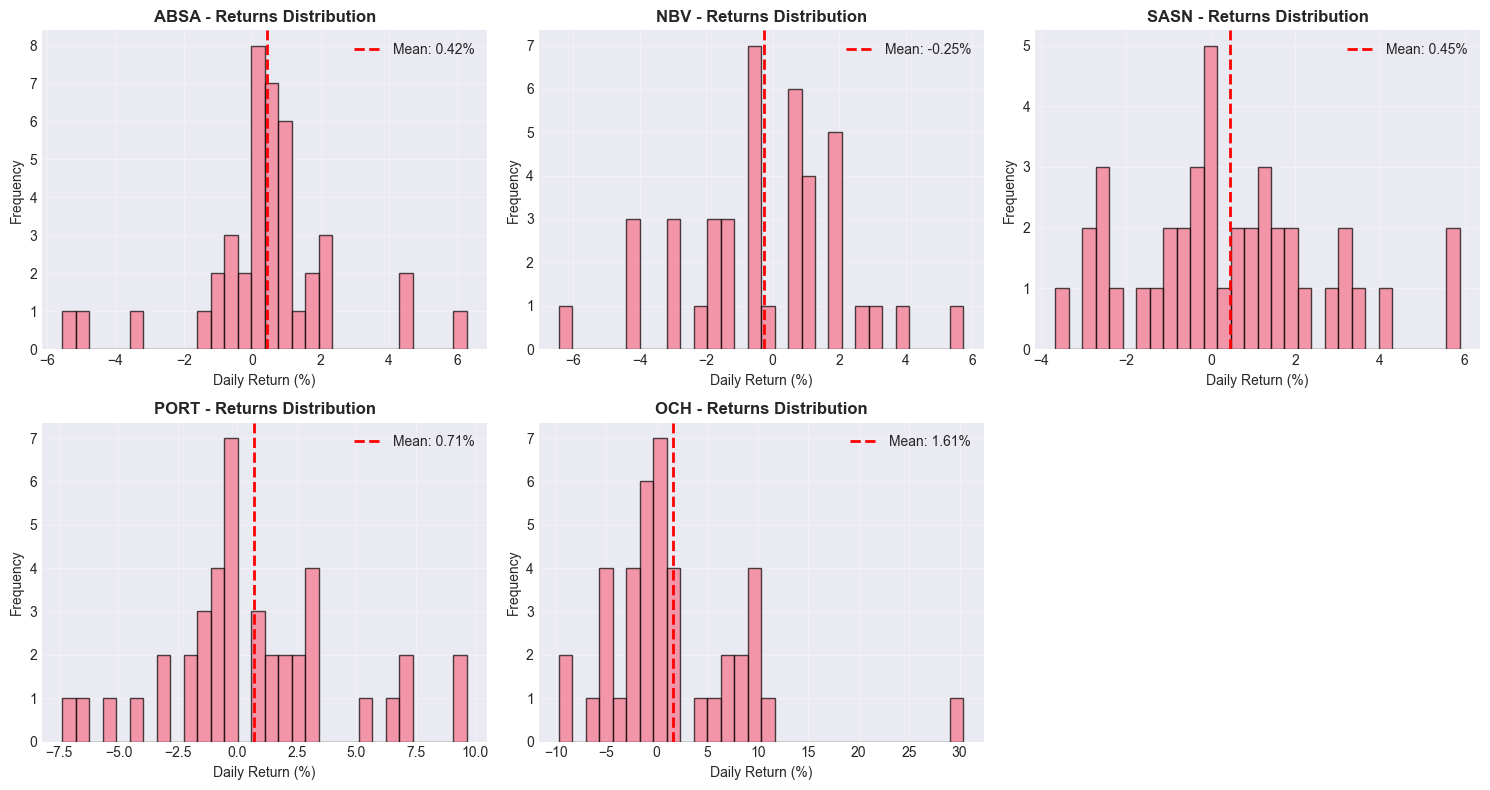


Volatility (Std Dev of Returns):
symbol
OCH     7.028194
PORT    3.784980
NBV     2.397400
SASN    2.266681
ABSA    2.076705
Name: returns, dtype: float64


In [8]:
# Calculate daily returns
df_returns = []

for symbol in top_stocks:
    df_stock = df_all[df_all['symbol'] == symbol].sort_values('trading_date')
    df_stock['returns'] = df_stock['close_price'].pct_change() * 100
    df_returns.append(df_stock[['symbol', 'trading_date', 'returns']].dropna())

df_returns = pd.concat(df_returns)

# Distribution of returns
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, symbol in enumerate(top_stocks):
    returns = df_returns[df_returns['symbol'] == symbol]['returns']
    
    axes[idx].hist(returns, bins=30, alpha=0.7, edgecolor='black')
    axes[idx].axvline(returns.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {returns.mean():.2f}%')
    axes[idx].set_title(f'{symbol} - Returns Distribution', fontweight='bold')
    axes[idx].set_xlabel('Daily Return (%)')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

# Volatility (standard deviation of returns)
volatility = df_returns.groupby('symbol')['returns'].std().sort_values(ascending=False)
print("\nVolatility (Std Dev of Returns):")
print(volatility)

### 3.4 Correlation Analysis

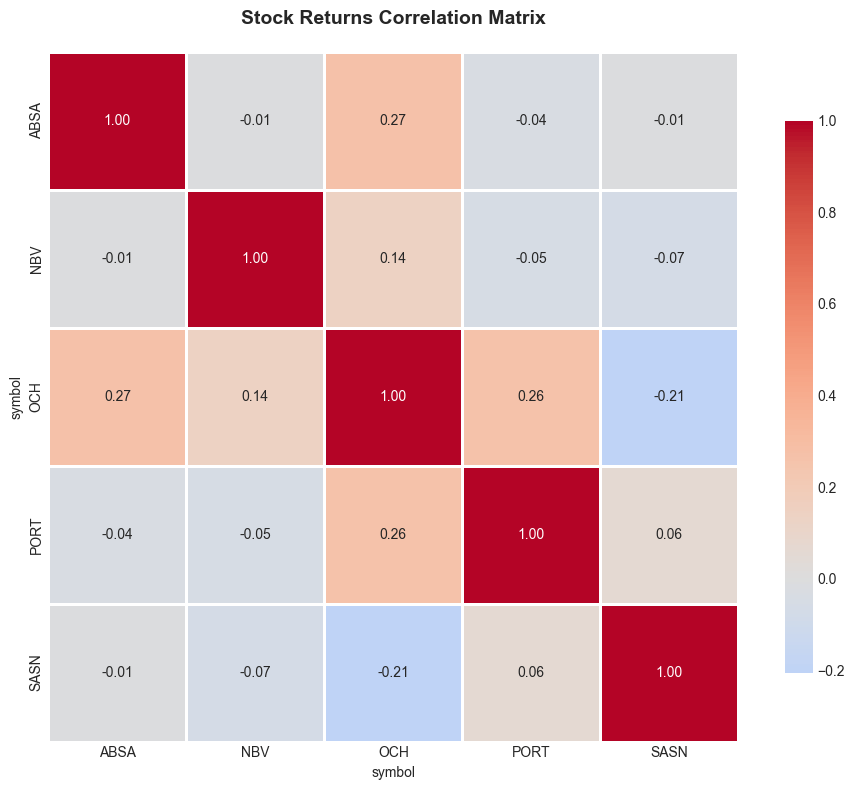

In [9]:
# Pivot returns for correlation
returns_pivot = df_returns.pivot(index='trading_date', columns='symbol', values='returns')

# Correlation matrix
corr_matrix = returns_pivot.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Stock Returns Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

---
## 4. Model Development

### Select Stock for Detailed Analysis

We'll use one stock for detailed model comparison, then apply to all stocks.

In [10]:
# Select stock with most data
ANALYSIS_SYMBOL = top_stocks[0]
print(f"Selected stock for detailed analysis: {ANALYSIS_SYMBOL}")

# Get data for this stock
df_analysis = df_all[df_all['symbol'] == ANALYSIS_SYMBOL].sort_values('trading_date').reset_index(drop=True)

print(f"\nData points: {len(df_analysis)}")
print(f"Date range: {df_analysis['trading_date'].min()} to {df_analysis['trading_date'].max()}")
print(f"Price range: {df_analysis['close_price'].min():.2f} - {df_analysis['close_price'].max():.2f} KES")

df_analysis.tail(10)

Selected stock for detailed analysis: ABSA

Data points: 42
Date range: 2025-08-04 to 2025-11-01
Price range: 19.50 - 23.50 KES


,symbol,trading_date,close_price,daily_high,daily_low,daily_volume
32,ABSA,2025-09-17,23.30,23.50,23.00,1.126432e+10
33,ABSA,2025-09-18,22.50,23.50,22.00,1.249031e+08
34,ABSA,2025-09-19,21.25,23.30,20.50,6.127764e+07
35,ABSA,2025-09-22,20.20,22.80,19.80,2.218019e+07
36,ABSA,2025-09-23,20.00,21.00,19.70,1.305094e+08
37,ABSA,2025-09-24,20.35,21.00,19.70,9.743285e+07
38,ABSA,2025-09-25,20.70,21.25,20.00,1.494617e+08
39,ABSA,2025-10-16,22.00,22.05,21.80,4.688004e+06
40,ABSA,2025-10-25,22.50,22.70,21.80,1.019682e+08
41,ABSA,2025-11-01,23.00,23.10,22.45,5.674903e+07


### 4.1 LSTM Model

In [11]:
# Initialize LSTM predictor
lstm = LSTMPredictor(ANALYSIS_SYMBOL, lookback_days=10)

# Train model
print("Training LSTM model...")
lstm_metrics, lstm_history = lstm.train(df_analysis, test_size=0.2, epochs=50, batch_size=32)

# Display metrics
print("\n📊 LSTM Performance Metrics:")
for metric, value in lstm_metrics.items():
    print(f"  {metric}: {value:.4f}")

2025-11-01 04:57:58,921 - INFO - LSTM model built for ABSA
2025-11-01 04:57:58,922 - INFO - Training LSTM for ABSA with 9 samples...


Training LSTM model...


2025-11-01 04:58:01,575 - INFO - LSTM ABSA - RMSE: 0.39, MAE: 0.32, MAPE: 1.43%



📊 LSTM Performance Metrics:
  MSE: 0.1506
  RMSE: 0.3880
  MAE: 0.3229
  R2: 0.0965
  MAPE: 1.4346


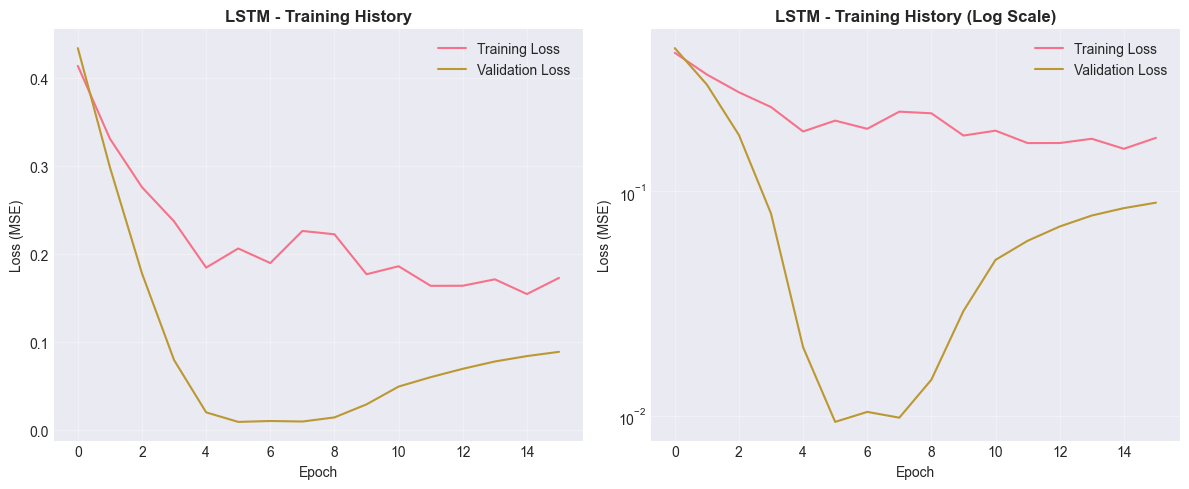

In [12]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM - Training History', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM - Training History (Log Scale)', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.yscale('log')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 RNN Model

In [13]:
# Initialize RNN predictor
rnn = RNNPredictor(ANALYSIS_SYMBOL, lookback_days=10)

# Train model
print("Training RNN model...")
rnn_metrics, rnn_history = rnn.train(df_analysis, test_size=0.2, epochs=50, batch_size=32)

# Display metrics
print("\n📊 RNN Performance Metrics:")
for metric, value in rnn_metrics.items():
    print(f"  {metric}: {value:.4f}")

2025-11-01 04:58:37,679 - INFO - RNN model built for ABSA
2025-11-01 04:58:37,679 - INFO - Training RNN for ABSA with 9 samples...


Training RNN model...


2025-11-01 04:58:39,601 - INFO - RNN ABSA - RMSE: 0.49, MAE: 0.44, MAPE: 1.96%



📊 RNN Performance Metrics:
  MSE: 0.2443
  RMSE: 0.4943
  MAE: 0.4382
  R2: -0.4659
  MAPE: 1.9633


### 4.3 Prophet Model

In [14]:
# Initialize Prophet predictor
prophet = ProphetPredictor(ANALYSIS_SYMBOL)

# Train model
print("Training Prophet model...")
prophet_metrics = prophet.train(df_analysis, test_size=0.2)

# Display metrics
print("\n📊 Prophet Performance Metrics:")
for metric, value in prophet_metrics.items():
    print(f"  {metric}: {value:.4f}")

2025-11-01 04:58:44,985 - INFO - Training Prophet for ABSA with 33 samples...
2025-11-01 04:58:45,019 - INFO - Chain [1] start processing


Training Prophet model...


2025-11-01 04:58:46,419 - INFO - Chain [1] done processing
2025-11-01 04:58:46,434 - INFO - Prophet ABSA - RMSE: 10.42, MAE: 8.10, MAPE: 37.02%



📊 Prophet Performance Metrics:
  MSE: 108.4952
  RMSE: 10.4161
  MAE: 8.0973
  R2: -93.3082
  MAPE: 37.0177


---
## 5. Model Comparison


MODEL COMPARISON - ABSA
                MSE       RMSE       MAE         R2       MAPE
LSTM       0.150579   0.388045  0.322927   0.096526   1.434565
RNN        0.244317   0.494285  0.438246  -0.465905   1.963257
Prophet  108.495169  10.416101  8.097311 -93.308190  37.017738


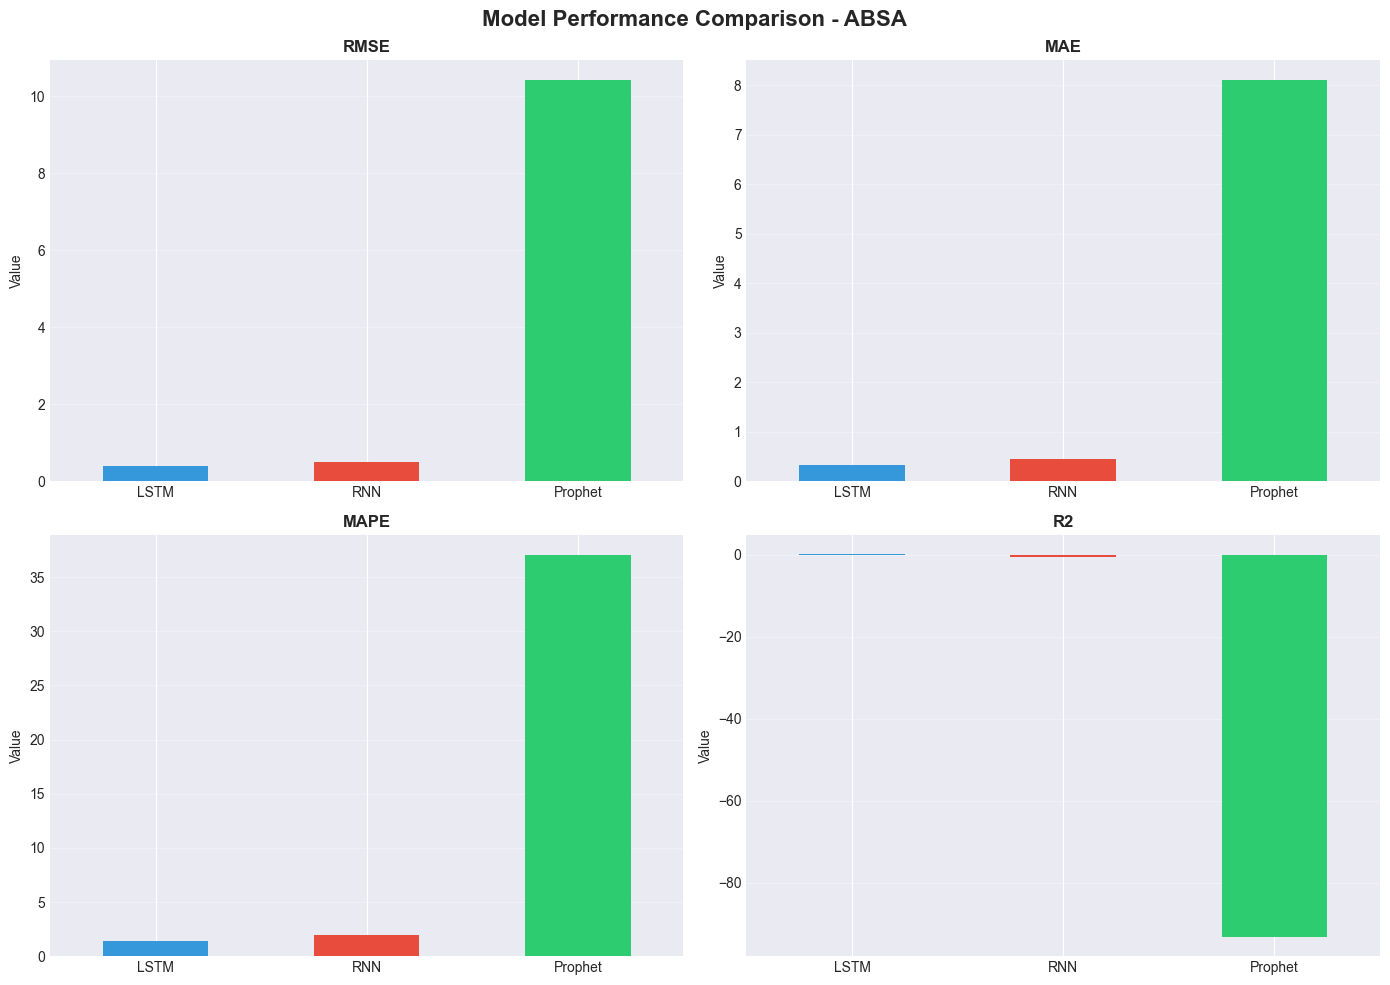

In [15]:
# Compare metrics
comparison_df = pd.DataFrame({
    'LSTM': lstm_metrics,
    'RNN': rnn_metrics,
    'Prophet': prophet_metrics
}).T

print("\n" + "="*60)
print(f"MODEL COMPARISON - {ANALYSIS_SYMBOL}")
print("="*60)
print(comparison_df.to_string())
print("="*60)

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Model Performance Comparison - {ANALYSIS_SYMBOL}', fontsize=16, fontweight='bold')

metrics = ['RMSE', 'MAE', 'MAPE', 'R2']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    comparison_df[metric].plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c', '#2ecc71'])
    ax.set_title(metric, fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### Next Day Predictions

In [16]:
# Make predictions for next day
lstm_pred = lstm.predict_next_day(df_analysis)
rnn_pred = rnn.predict_next_day(df_analysis)
prophet_pred = prophet.predict_next_day(df_analysis)

current_price = df_analysis['close_price'].iloc[-1]

print(f"\n{'='*60}")
print(f"{ANALYSIS_SYMBOL} - NEXT DAY CLOSING PRICE PREDICTIONS")
print(f"{'='*60}")
print(f"Current Price:  {current_price:.2f} KES")
print(f"\nPredictions:")
print(f"  LSTM:    {lstm_pred:.2f} KES ({((lstm_pred/current_price - 1)*100):+.2f}%)")
print(f"  RNN:     {rnn_pred:.2f} KES ({((rnn_pred/current_price - 1)*100):+.2f}%)")
print(f"  Prophet: {prophet_pred:.2f} KES ({((prophet_pred/current_price - 1)*100):+.2f}%)")
print(f"\nEnsemble (Average): {np.mean([lstm_pred, rnn_pred, prophet_pred]):.2f} KES")
print(f"{'='*60}")


ABSA - NEXT DAY CLOSING PRICE PREDICTIONS
Current Price:  23.00 KES

Predictions:
  LSTM:    22.54 KES (-2.01%)
  RNN:     22.75 KES (-1.08%)
  Prophet: 34.61 KES (+50.46%)

Ensemble (Average): 26.63 KES


---
## 6. Apply to All Stocks

In [20]:
# Get stocks with sufficient data
sufficient_data_stocks = stock_counts[stock_counts >= 60].index.tolist()
print(f"Processing {len(sufficient_data_stocks)} stocks with 60+ days of data...\n")

# Initialize comparator
comparator = ModelComparator()

# Process each stock (limit to 5 for demonstration)
for idx, symbol in enumerate(sufficient_data_stocks[:5], 1):
    print(f"\n[{idx}/{min(5, len(sufficient_data_stocks))}] Processing {symbol}...")
    
    df_stock = df_all[df_all['symbol'] == symbol].sort_values('trading_date')
    
    try:
        # LSTM
        lstm_model = LSTMPredictor(symbol, lookback_days=10)
        lstm_m, _ = lstm_model.train(df_stock, epochs=50, batch_size=32)
        lstm_p = lstm_model.predict_next_day(df_stock)
        comparator.add_result(symbol, 'LSTM', lstm_m, lstm_p)
        
        # RNN
        rnn_model = RNNPredictor(symbol, lookback_days=10)
        rnn_m, _ = rnn_model.train(df_stock, epochs=50, batch_size=32)
        rnn_p = rnn_model.predict_next_day(df_stock)
        comparator.add_result(symbol, 'RNN', rnn_m, rnn_p)
        
        # Prophet
        prophet_model = ProphetPredictor(symbol)
        prophet_m = prophet_model.train(df_stock)
        prophet_p = prophet_model.predict_next_day(df_stock)
        comparator.add_result(symbol, 'Prophet', prophet_m, prophet_p)
        
        print(f"  ✅ {symbol} completed")
        
    except Exception as e:
        print(f"  ❌ {symbol} failed: {str(e)}")
        continue

print("\n✅ All stocks processed!")

Processing 0 stocks with 60+ days of data...


✅ All stocks processed!


---
## 7. Results Summary

In [22]:
# Get results
results_df = comparator.get_comparison_df()

print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)


FINAL RESULTS SUMMARY
Empty DataFrame
Columns: []
Index: []


In [23]:
# Average performance by model
avg_performance = results_df.groupby('model')[['RMSE', 'MAE', 'MAPE', 'R2']].mean()

print("\nAverage Performance by Model:")
print(avg_performance.to_string())

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Average Model Performance Across All Stocks', fontsize=16, fontweight='bold')

metrics = ['RMSE', 'MAE', 'MAPE', 'R2']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    avg_performance[metric].plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c', '#2ecc71'])
    ax.set_title(metric, fontweight='bold')
    ax.set_ylabel('Average Value')
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

KeyError: 'model'

---
## 8. Conclusions

In [ ]:
# Find best model overall
best_model_by_rmse = avg_performance['RMSE'].idxmin()
best_model_by_r2 = avg_performance['R2'].idxmax()

print("\n" + "="*80)
print("CONCLUSIONS")
print("="*80)
print(f"Best model by RMSE: {best_model_by_rmse} ({avg_performance.loc[best_model_by_rmse, 'RMSE']:.4f})")
print(f"Best model by R²:   {best_model_by_r2} ({avg_performance.loc[best_model_by_r2, 'R2']:.4f})")
print(f"\nAverage MAPE: {avg_performance['MAPE'].min():.2f}% (best)")
print(f"Average MAE:  {avg_performance['MAE'].min():.4f} KES (best)")
print("="*80)

### Key Findings

1. **Model Performance**: [Write your analysis here]
2. **LSTM vs RNN**: [Compare the two]
3. **Deep Learning vs Traditional**: [LSTM/RNN vs Prophet]
4. **Practical Implications**: [For traders/investors]
5. **Limitations**: [What to be aware of]

### Future Work

1. Incorporate more features (technical indicators, sentiment)
2. Ensemble methods (combine all three models)
3. Hyperparameter tuning
4. Real-time deployment
5. Extended backtesting

---
## 9. Export Results for Thesis

In [ ]:
# Save results
import os
os.makedirs('thesis_results', exist_ok=True)

# Save comparison table
results_df.to_csv('thesis_results/model_comparison.csv', index=False)
avg_performance.to_csv('thesis_results/average_performance.csv')

print("✅ Results exported to thesis_results/ directory")
print("\nFiles created:")
print("  - model_comparison.csv")
print("  - average_performance.csv")
print("\nUse these files in your thesis document!")